# RecSegImage-LA: Reconstruction, Segmentation of LA-ICP Imaging Data

In [1]:
import sys
sys.path.append("../") # go to parent dir

from recsegimage import *

import numpy as np
import matplotlib.pyplot as plt
import glob
import re
%matplotlib inline

## Reconstruction of images for all the analyzed metals

The following lines of code perform image reconstruction of LA-ICP-MS data, save the data in the results folder and generate plots of the reconstructed images. The final images are in order of acquisition in the raw data (Metal1, Metal2, Metal3, ... , Metaln)

* foldername = string, name of the folder that includes the raw data files and the ipython script RecSegImage-LA.ipynb
* data_name = string, name given to the data (no blank spaces allowed in the name)
* spot_size = integer, spot size in microns of the laser used to acquire the data
* scan_rate = integer, scan rate of the laser in microns/second
* nmetals = integer, number of metals analyzed, when performing the images
* ldiscard = integer, number of columns on the far left side of the image to be eliminated in case there is sample carryover. Default value is 0

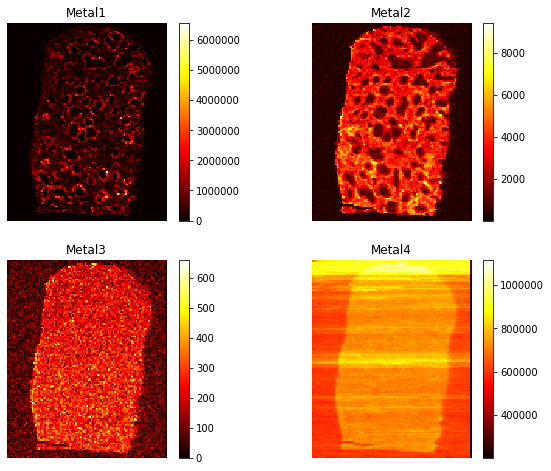

In [2]:
foldername = "data/" 
data_name = "Example" 
spot_size = 50
scan_rate = 15
nmetals = 4
ldiscard = 0

# Image reconstruction of the LA-ICP-MS raw data
final_matrices,sumdata = image_reconstruction(foldername,ldiscard,"*.xl",nmetals,spot_size,scan_rate) 

# Save the analysis in .csv files in the folder RegSegImage-LA/results folder
write_data_analysis(final_matrices,ldiscard,sumdata,nmetals)

# Generate the image plots of all the analyzed metals
generate_plot_all_metals(final_matrices, nmetals)

## Reconstruction of the image of a single metal

Image reconstruction of one of all the analyzed metals. The metal index of the metal needs to be specified. The metal index corresponds to the order in which the metal is analyzed by the ICP-MS. For this particular example, the ICP-MS performs the readings of the metals in the following order: Bi, Fe, Zn, S. This means that the associated indexes are: Bi (Metal1, metal_index=1), Fe (Metal2, metal_index=2), Zn (Metal3, metal_index=3) and S (Metal4, metal_index=4)

* metal_index = integer, index of the metal that we want to plot. For example, for Metal 2 (Fe), the index is 2. 

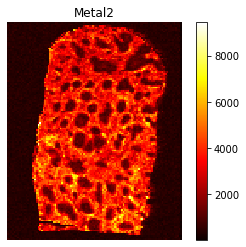

In [3]:
metal_index = 2

# Functions to generate image of one metal plot
generate_metal_plot(final_matrices,metal_index,nmetals)

## Background Subtraction

Use the Zn image (or other metal that marks the tissue boundary) to differentiate tissue from background

* background_index = integer, index of the image used for background subtraction. In this case is the Zn image
* line = integer, row or column from which the standard deviation will be calculated. By default, the value is 1, which corresponds to the first row and column. The script will calculate the smallest standard deviation among the selected rows and columns
* std_threshold = integer, how many standard deviations will be tolerated to set the threshold of what is considered to be tissue and background

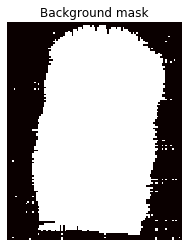

In [4]:
background_index = 3
line = 1
std_threshold = 4

background_mask = remove_background(final_matrices,background_index,line,std_threshold)
background_plot = generate_background_plot(background_mask)

## Normalization with background subtraction

Normalization of the image with background subtraction. Background subtraction should be done first to obtain the background mask. The normalization corresponds to a pixel/pixel division of the images, so metal_numerator/metal_denominator should be specified in the following parameters:

* metal_numerator = integer, index of the metal that will correspond to the metal numerator in the division operation
* metal_denominator = integer, index of the metal that will correspond to the metal denominator in the division operation

The normalized image with background subtraction is saved as a text file in the results folder. The name of the file is: "Normalization Background Metal_numerator / Metal_denominator"

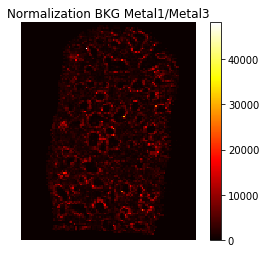

In [5]:
metal_numerator = 1
metal_denominator = 3

normalization_with_background(final_matrices,background_mask,metal_numerator,metal_denominator)

## k-means segmentation

Segmentation of the images using k-means clustering. This is without spatial awareness.

* metal_segmentation_index = integer, index of the metal used for segmentation. In this example we use Fe and the index of Fe in the reconstructed data corresponds to 2
* clusters = integer, number of clusters to perform k-means segmentation. For this particular common example we had determined that the ideal number of clusters is 2

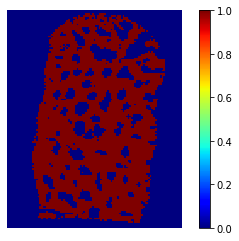

In [6]:
metal_segmentation_index = 2
segmentation_clusters = 2

label_image,segmented_image = segmentation(final_matrices,background_mask,metal_segmentation_index,segmentation_clusters) 

## k-means multimetal segmentation with neighboring pixel evaluation

Application of neighboring pixel evaluation using average filtering. The k-means segmentation part of the code should be run first before performing neighboring pixel evaluation. The number of clusters and metal segmentation index are the ones specified in the k-means segmentation part of the code. If the user wants to change these parameters, this can be done in the k-means segmentation part of the code. No inputs are required here by the user

Multimetal segmented images correspond to the segmented images using Fe and the background mask (Zn) for segmentation. A weighted image corresponds to the image after filtering to determine the tissue boundaries.

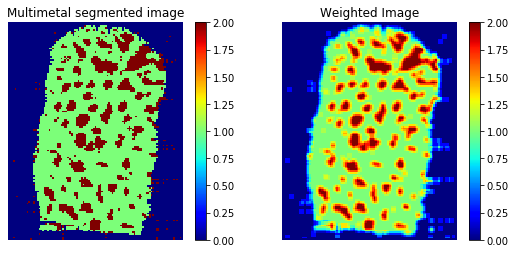

In [7]:
weighted_pixels = neighbouring_average(label_image,background_mask)

## Image masks of the segmented areas

It is possible to set up to four diferent areas determined by segmentation and neighboring pixel evaluation. It is necessary to set up the cutoffs of the areas in relation to the weighted image (0 to 18 scale). For this particular example we set up the cutoff values for:

Area 1 = Background (values between 0 and 5)
Area 2 = Red Pulp (values between 6 and 10)
Area 3 = Marginal zone (values between 11 and 14)
Area 4 = White pulp (values between 15 and 18)

The variables shown should specify the low and high cutoff of a particular area:

* low_A1 = integer, low cutoff of Area 1
* high_A1 = integer, high cutoff of Area 1
* low_A2 = integer, low cutoff of Area 2
* high_A2 = integer, high cutoff of Area 2
* low_A3 = integer, low cutoff of Area 3
* high_A3 = integer, high cutoff of Area 3
* low_A4 = integer, low cutoff of Area 4
* high_A4 = integer, high cutoff of Area 4

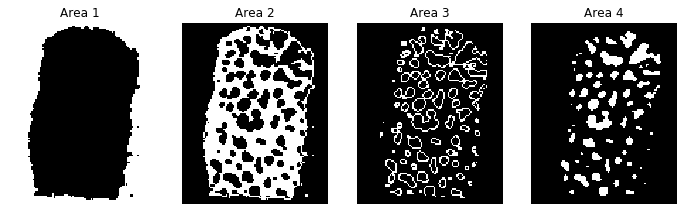

In [8]:
low_A1 = 0
high_A1 = 0.59

low_A2 = 0.60
high_A2 = 1.19

low_A3 = 1.20
high_A3 = 1.49

low_A4 = 1.50
high_A4 = 2.0

area1,area2,area3,area4 = image_masks(weighted_pixels,low_A1,high_A1,low_A2,high_A2,low_A3,high_A3,low_A4,high_A4)

## Quantitation in different segments

Quantitation of pixels in the different segments determined by the image masks. Four different areas of a tissue were determined after segmentation. The segmented areas can be use to get the number of pixels in each of the particular areas, find the average and error of any of the metals in each of the segmented areas. It is necessary to choose the metal that we desire to quantify in each of the areas as the (quantitation_index). In this particular example, we want to quantify the Bismuth (quantitation_index=1) so the index needs to be set to the Bi index (Bismuth index is 1). It is also possible to quantify the average signal of any of the other metals, for example if we want to quantify the Fe in each of the segmented areas we should set (quantitation_index=2) as the Fe corresponds to the metal with the index=2.

* quantitation_index = int, index of the metal that we want to quantify in each of the segments

In [9]:
quantitation_index = 2

quantitation_segments(final_matrices,area1,area2,area3,area4,quantitation_index)

Area 1 Quantitation:
Area 1 pixels are: 5308
Area 1 average is: 518.7432395475972
Area 1 error is: 7.172345137306754
 
Area 2 Quantitation:
Area 2 pixels are: 4822
Area 2 average is: 3890.3483368180314
Area 2 error is: 15.287243249381316
 
Area 3 Quantitation:
Area 3 pixels are: 1545
Area 3 average is: 2777.1852567092023
Area 3 error is: 23.262159826047085
 
Area 4 Quantitation:
Area 4 pixels are: 1509
Area 4 average is: 1337.1421460333133
Area 4 error is: 9.673310098229521
